# CS224 - Winter 2023
## Extra Credit - EM Algorithm
## DUE March 23, 2023 @ 5:00pm PDT
## THIS IS A COMPLETELY OPTIONAL PROBLEM SET

**Submission Method**: Export the Jupyter notebook as **PDF** and submit the PDF file on **Gradescope**. (For more details, see the Assignment Guidelines.)

**Maximum points**: 5

<div style="margin-bottom: 15px; padding: 15px; color: #31708f; background-color: #d9edf7; border: 1px solid #bce8f1; border-radius: 5px;">
    
<b><font size=+2>Enter your information below:</font></b></br></br>

  <b>(full) Name</b>: YASH AGGARWAL
  </br>
  
  <b>Student ID Number</b>:  862333037
  </br></br>
    
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>
</div>

<div style="padding: 15px; color: #8a6d3b; background-color: #fcf8e3; border: 1px solid #faebcc; border-radius: 5px;">
<b><font size=+2>Academic Integrity</font></b></br> 
Each assignment should be done  individually. You may discuss general approaches with other students in the class, and ask questions to the TA, but  you must only submit work that is yours . If you receive help by any external sources (other than the TA and the instructor), you must properly credit those sources. The UCR Academic Integrity policies are available at <a href="http://conduct.ucr.edu/policies/academicintegrity.html" target="_blank">http://conduct.ucr.edu/policies/academicintegrity.html</a>.
</div>

# Overview 
This problem is related to estimating the parameters of a Gaussian Mixture Model(GMM) using expectation maximization (EM).

For this assignment we will use the functionality of [Numpy](http://www.numpy.org/), and [Matplotlib](https://matplotlib.org/).

*   Before you start, make sure you have installed all those packages in your local Jupyter instance.
*   If you are asked to implement a particular functionality, you should **not** use an existing implementation from the libraries above (or some other library that you may find). When in doubt, **please just ASK**.


Please read **all** cells carefully and answer **all** parts (both text and missing code). You will need to complete all the code marked `TODO` and answer descriptive/derivation questions.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# DO NOT REMOVE THE CODE ABOVE

## Generate data from a GMM [1 point]
Generate data from a GMM that you specify with at least 3 components.
- you need to implement the GMM generator on your own. Using functions like `sklearn.mixture.GaussianMixture()` will **not** give you any credit.
- You can use functions in `numpy.random` to generate your data.

In [ ]:
# TODO

# Define the means matrix 2D
means = np.array([
    [-4, 0], 
    [0, 4], 
    [4, 0]
])

#Define the covariance matrix
covariances = np.array([
    [[1, 0.5], 
     [0.5, 1]], 
    [[1, 0], 
     [0, 1]], 
    [[1, -0.5], 
     [-0.5, 1]]])

mixing_probabilities = [0.3, 0.5, 0.2]

#Define variables
n_samples = 900
n_components = 3
n_samples_per_component = int(n_samples/n_components)

# Initialize all samples and labels as 0,0 and 0
samples = np.zeros((n_samples, means.shape[1]))
labels = np.zeros((n_samples))

# Generate new samples 
for i in range(len(samples)):

    # randomly generate cluster index
    cluster_index = np.random.choice(n_components, p=mixing_probabilities)
    
    # generate point belonging to that cluster
    samples[i,:] = np.random.multivariate_normal(mean=means[cluster_index], cov=covariances[cluster_index])
    
    # add cluster index as respective label
    labels[i] = cluster_index

print (samples.shape)
print (np.unique(labels, return_counts=True))

(900, 2)
(array([0., 1., 2.]), array([295, 423, 182]))


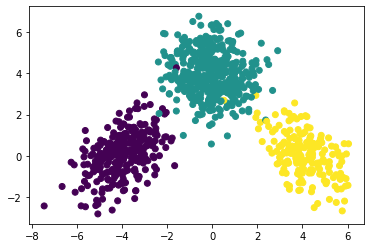

In [ ]:
def plot_samples(samples, labels):
    plt.figure(0)
    plt.scatter(samples[:,0], samples[:,1],c=labels)
    
plot_samples(samples, labels)

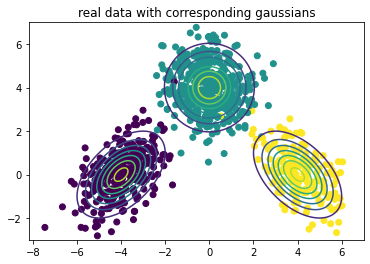

In [ ]:
def plot_samples_with_gaussians(samples, labels, mus, covs, title='none'):
    plt.figure(0)
    plt.scatter(samples[:,0], samples[:,1],c=labels)

    if title != 'none':
        plt.title(title)

    for mu,cov in zip(mus,covs):
        x_min, x_max = mu[0] - 3 * np.sqrt(cov[0, 0]), mu[0] + 3 * np.sqrt(cov[0, 0])
        y_min, y_max = mu[1] - 3 * np.sqrt(cov[1, 1]), mu[1] + 3 * np.sqrt(cov[1, 1])
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
        pos = np.empty(xx.shape + (2,))
        pos[:, :, 0] = xx
        pos[:, :, 1] = yy

        # Create the Gaussian distribution
        inv_cov = np.linalg.inv(cov)
        det_cov = np.linalg.det(cov)
        normalization = 1.0 / (2.0 * np.pi * np.sqrt(det_cov))
        z = np.zeros(xx.shape)
        for i in range(xx.shape[0]):
            for j in range(xx.shape[1]):
                x = pos[i, j, :]
                exponent = -0.5 * np.dot(np.dot((x - mu), inv_cov), (x - mu).T)
                z[i, j] = normalization * np.exp(exponent)

        # Plot the contours
        plt.contour(xx, yy, z)
    plt.show()

plot_samples_with_gaussians(samples, labels, means, covariances, title = 'real data with corresponding gaussians')

## Estimation using EM with accurate number of components [2 points]
Now assume that you have only the data and know nothing about the model, **except** the number of components.

Use the EM to estimate the parameters of the GMM (parameters of each Gaussian and their mixing values), and compare with the ground truth values used in generating the data. 

- You need to actually write the code for the main steps of the algorithm. Do **not** existing software function.
- You can use built-in functions in `np.linalg` to do the matrix operation for parts within the main EM algorithm.

In [ ]:
# compute log_likelihood similar to multivariate_normal_pdf, 
# but for single components and then add
def log_likelihood(X, responsibilities, means, covs):
    
    n, d = X.shape
    k = responsibilities.shape[1]
    likelihoods = np.zeros((n, k))

    for j in range(k):
    
        diff = X - means[j]
        inv_sigma = np.linalg.inv(covs[j])
        coef = 1.0 / np.sqrt((2*np.pi)**d * np.linalg.det(covs[j]))
        exponent = -0.5 * np.sum(np.dot(diff, inv_sigma) * diff, axis=1)
        likelihoods[:, j] = coef * np.exp(exponent)
    
    log_likelihoods = np.log(np.sum(likelihoods * responsibilities, axis=1))
    return np.sum(log_likelihoods)

# Compute multivariate probability density function
def multivariate_normal_pdf(x, mean, cov):

    d = mean.shape[0]
    coef = 1 / ((2 * np.pi)**(d/2) * np.linalg.det(cov)**0.5)
    diff = x - mean
    inv_cov = np.linalg.inv(cov)
    exponent = -0.5 * np.sum(np.dot(diff, inv_cov) * diff, axis=-1)
    p = coef * np.exp(exponent)
    return p

# E-step: compute the responsibilities
def compute_responsibilities(samples, means, covariances, weights):
    
    n_samples = samples.shape[0]
    n_components = means.shape[0]

    responsibilities = np.zeros((n_samples, n_components))
    
    for i in range(n_components):
        responsibilities[:, i] = weights[i] * multivariate_normal_pdf(samples, mean=means[i], cov=covariances[i])

    responsibilities = responsibilities / np.sum(responsibilities, axis=1, keepdims=True)
    return responsibilities


# M-step: update the GMM parameters
def update_parameters(samples, responsibilities):

    n_samples = samples.shape[0]
    n_components = responsibilities.shape[1]
    
    weights = np.sum(responsibilities, axis=0) / n_samples
    means = np.zeros((n_components, 2))
    covariances = np.zeros((n_components, 2, 2))
    
    for i in range(n_components):
        means[i] = np.sum(responsibilities[:,i].reshape(-1, 1) * samples, axis=0) / np.sum(responsibilities[:, i])
        diff = samples - means[i]
        covariances[i] = np.dot(responsibilities[:, i] * diff.T, diff) / np.sum(responsibilities[:, i])
    

    LL = log_likelihood(samples, responsibilities, means, covariances)
    neg_log_likelihood = -LL/n_components

    return means, covariances, weights, neg_log_likelihood

In [ ]:
# TODO

# define the number of clusters to be learned
k = n_components

# create and initialize mixing probabilities
em_mixing_probabilities = np.ones((k)) / k

# create and initialize the cluster centers and co-var matrices
em_means = np.random.normal(size=(k, 2))
em_covariances = np.array([np.eye(2) for i in range(n_components)])

print(em_mixing_probabilities)
print(em_means)
print (em_covariances)

[0.33333333 0.33333333 0.33333333]
[[-0.84976167  0.31658486]
 [ 1.00204595 -0.7601922 ]
 [ 0.60322371  0.16881205]]
[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]


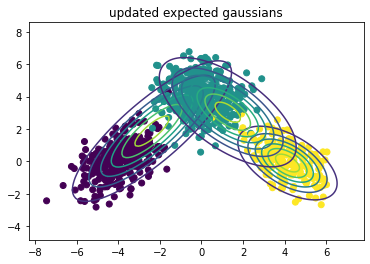

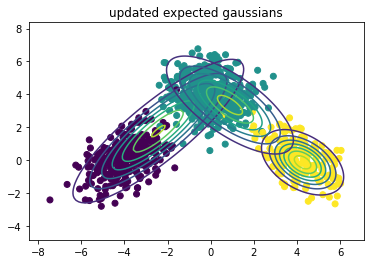

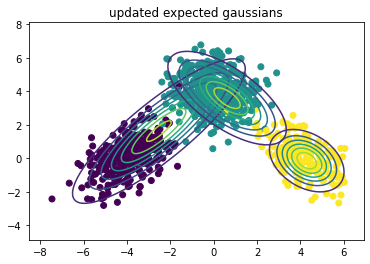

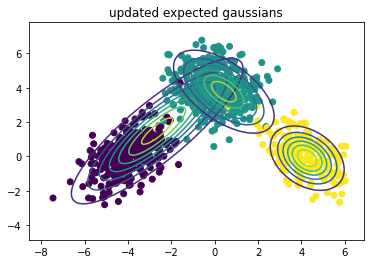

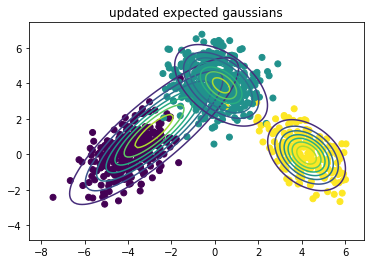

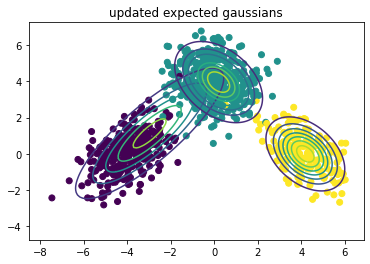

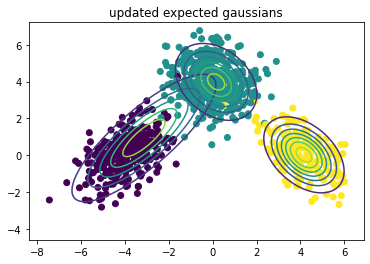

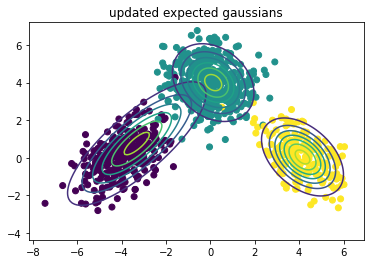

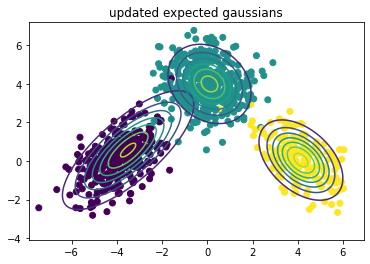

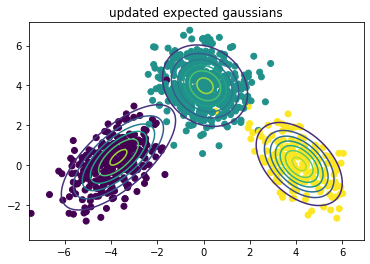

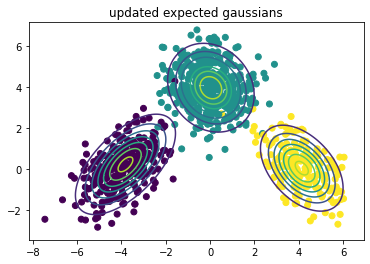

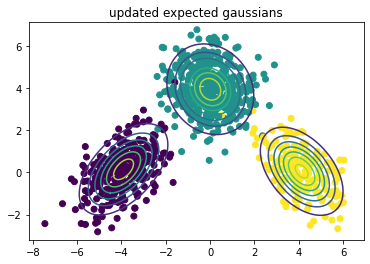

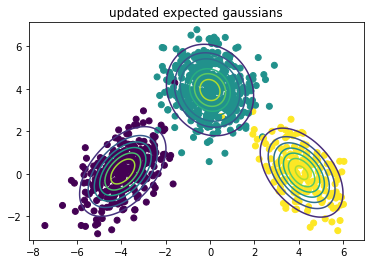

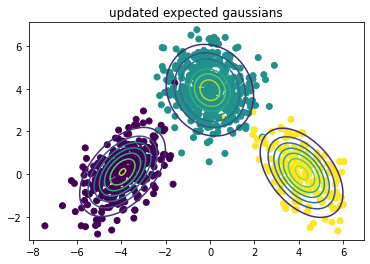

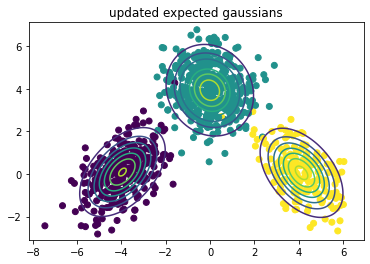

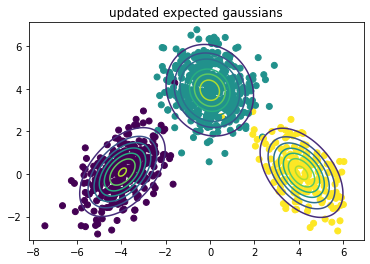

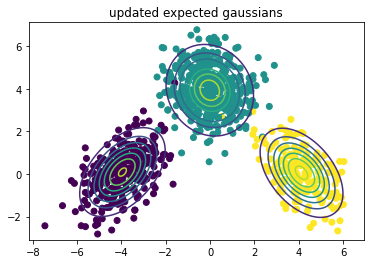

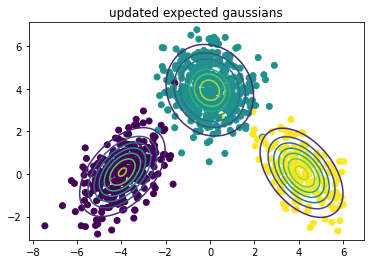

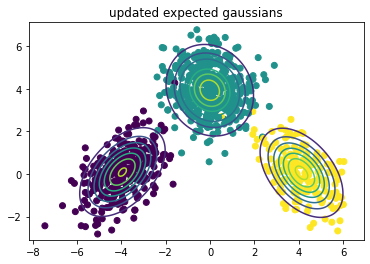

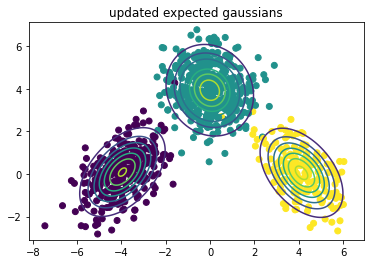

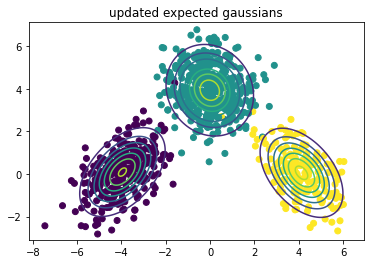

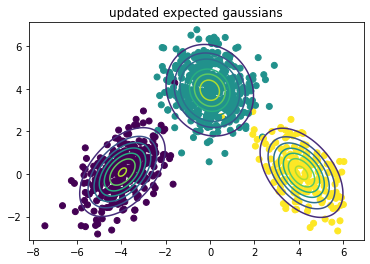

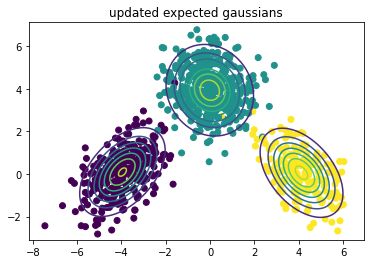

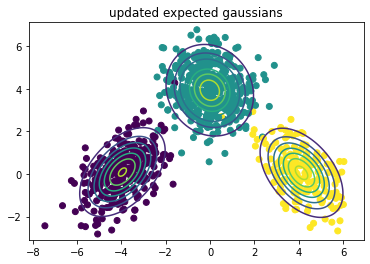

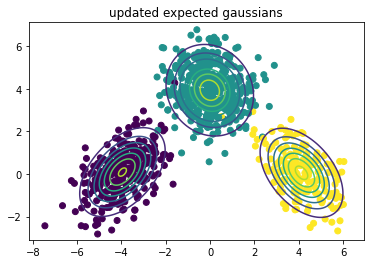

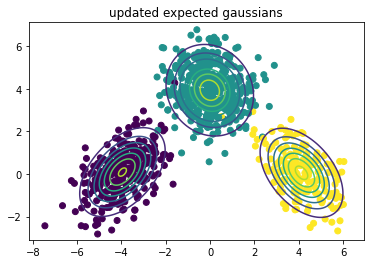

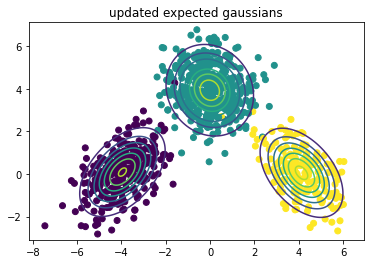

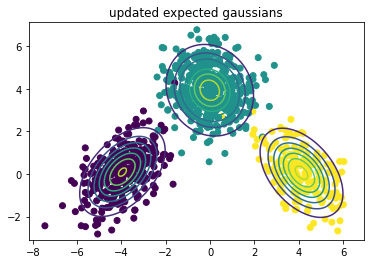

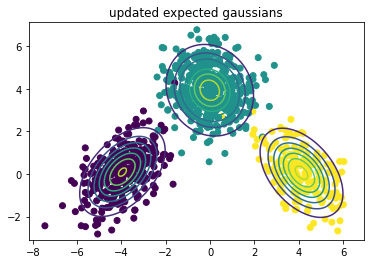

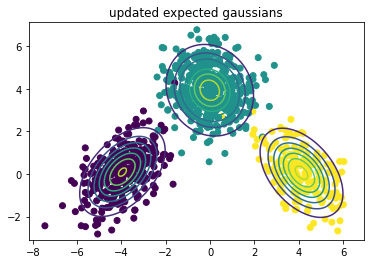

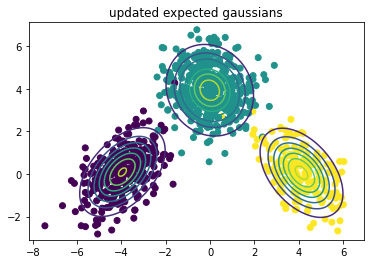

break by tolerence


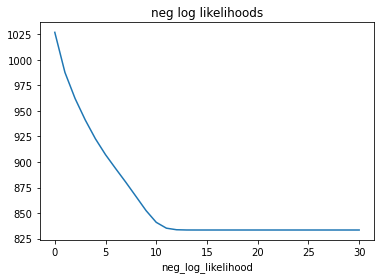

In [ ]:
# Run the EM algorithm
n_iter = 400
neg_log_likelihood_list = []
pre_likelihood = 0
em_responsibilities_list = []

for i in range(n_iter):

    responsibilities = compute_responsibilities(samples, em_means, em_covariances, em_mixing_probabilities)
    em_means, em_covariances, em_mixing_probabilities, neg_log_likelihood = update_parameters(samples, responsibilities)
    
    em_responsibilities_list.append(em_mixing_probabilities)
    neg_log_likelihood_list.append(neg_log_likelihood)
    plot_samples_with_gaussians(samples, labels,em_means,em_covariances,title='updated expected gaussians')

    if abs(pre_likelihood - neg_log_likelihood) <= 1e-9:
        print ('break by tolerence')
        break
    
    if i == n_iter-1:
        print ('break by iterations')
        break
        
    pre_likelihood = neg_log_likelihood

plt.figure(1)
plt.title('neg log likelihoods')
plt.xlabel('n_iters')
plt.xlabel('neg_log_likelihood')
plt.plot([i for i in range(len(neg_log_likelihood_list))], neg_log_likelihood_list)

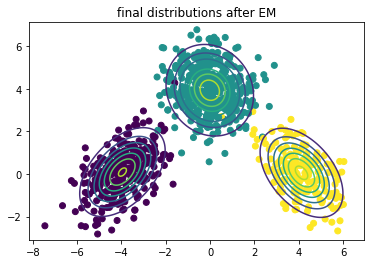

In [ ]:
plot_samples_with_gaussians(samples, labels,em_means,em_covariances, title='final distributions after EM')

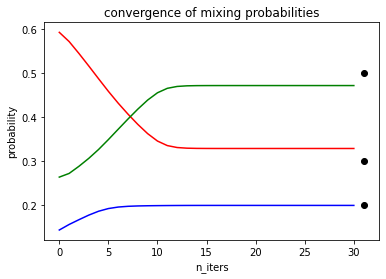

original responsibilities [0.3, 0.5, 0.2]
calculated responsibilities [0.32879786 0.19959295 0.47160919]


In [ ]:
em_responsibilities_list = np.array(em_responsibilities_list)

plt.figure(3)
plt.plot(np.arange(em_responsibilities_list.shape[0]), em_responsibilities_list[:,0],'r')
plt.plot(np.arange(em_responsibilities_list.shape[0]), em_responsibilities_list[:,1],'b')
plt.plot(np.arange(em_responsibilities_list.shape[0]), em_responsibilities_list[:,2],'g')
plt.scatter(em_responsibilities_list.shape[0], mixing_probabilities[0], c='black')
plt.scatter(em_responsibilities_list.shape[0], mixing_probabilities[1], c='black')
plt.scatter(em_responsibilities_list.shape[0], mixing_probabilities[2], c='black')
plt.title('convergence of mixing probabilities')
plt.xlabel('n_iters')
plt.ylabel('probability')
plt.show()

print ('original responsibilities', mixing_probabilities)
print ('calculated responsibilities', em_responsibilities_list[-1])

Analyze the results Vs. iterations of the EM algorithm progress by plotting two convergence plots: 
1. average negative log-likelihood(NLL) vs. iterations
2. estimated value of parameters vs. iterations

Study and report what you observe about the parameter estimation process.

Observations:
1. As the number of iterations increase, the NLL tends to decrease. This because the model is getting better at predicting the expectation of respective samples and thus the loss decreases.
2. The estimated value of parameters either increase or decrease based on the ground truth value, the inital assumption and the final value. The change is such that the final predicted value is closest to the ground truth value.

## Estimation using EM without accurate number of components [2 points]
Repeat the parameter estimation part without accurate knowledge of the number of components.

You may want to iterate over multiple values of the number of components. Study and report what you observe about the parameter estimation process.

In [ ]:
# TODO
neg_best_log_likelihood_list = []
for i in range(1,15):
    # Run the EM algorithm
    n_iter = 800
    prev_likelihood = 0

    k = i

    # create and initialize mixing probabilities
    em_mixing_probabilities = np.ones((k)) / k

    # create and initialize the cluster centers and co-var matrices
    em_means = np.random.normal(size=(k, 2))
    em_covariances = np.array([np.eye(2) for i in range(k)])


    for j in range(n_iter):
        responsibilities = compute_responsibilities(samples, em_means, em_covariances, em_mixing_probabilities)
        em_means, em_covariances, em_mixing_probabilities, neg_log_likelihood = update_parameters(samples, responsibilities)

        if abs(prev_likelihood - neg_log_likelihood) <= 1e-8:
            neg_best_log_likelihood_list.append(neg_log_likelihood)
            print ('break by tolerence')
            break
        
        if j == n_iter-1:
            neg_best_log_likelihood_list.append(neg_log_likelihood)
            print ('break by iterations')
            break

        prev_likelihood = neg_log_likelihood

    # plot_samples_with_gaussians(samples, labels,em_means,em_covariances)

break by tolerence
break by tolerence
break by tolerence
break by iterations
break by iterations
break by iterations
break by tolerence
break by tolerence
break by iterations
break by iterations
break by tolerence
break by iterations
break by iterations
break by iterations


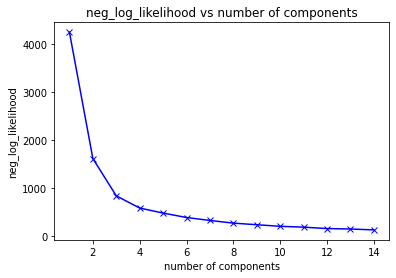

In [ ]:
plt.figure(1)
plt.plot(np.arange(1, len(neg_best_log_likelihood_list)+1), neg_best_log_likelihood_list, 'bx-')
plt.title('neg_log_likelihood vs number of components')
plt.xlabel('number of components')
plt.ylabel('neg_log_likelihood')
plt.show()

Observations:
1. There is a sharp drop when number of components are dropped from  1 to 3 and then the decline is slower. This means the ideal number of components should be around 3. This seems correct as the original data was generated for 3 components.

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc -qq
!pip install pypandoc -qq

In [ ]:
!jupyter nbconvert --to PDF "./extra_EM.ipynb"

[NbConvertApp] Converting notebook ./extra_EM.ipynb to PDF
[NbConvertApp] Support files will be in extra_EM_files/
[NbConvertApp] Making directory ./extra_EM_files
[NbConvertApp] Making directory ./extra_EM_files
[NbConvertApp] Making directory ./extra_EM_files
[NbConvertApp] Making directory ./extra_EM_files
[NbConvertApp] Making directory ./extra_EM_files
[NbConvertApp] Making directory ./extra_EM_files
[NbConvertApp] Making directory ./extra_EM_files
[NbConvertApp] Making directory ./extra_EM_files
[NbConvertApp] Making directory ./extra_EM_files
[NbConvertApp] Making directory ./extra_EM_files
[NbConvertApp] Making directory ./extra_EM_files
[NbConvertApp] Making directory ./extra_EM_files
[NbConvertApp] Making directory ./extra_EM_files
[NbConvertApp] Making directory ./extra_EM_files
[NbConvertApp] Making directory ./extra_EM_files
[NbConvertApp] Making directory ./extra_EM_files
[NbConvertApp] Making directory ./extra_EM_files
[NbConvertApp] Making directory ./extra_EM_files
[Nb